In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from math import e
from joblib import dump, load
import xskillscore as xs
import cartopy.crs as ccrs
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.cm as mpl_cm
from eofs.xarray import Eof

# Fog CNN

In [2]:
CNN = load('../../March2021/Observation_models/CNNY.joblib').sel(time=slice('1980-12-1','2014-1-31'))
CNN

<xarray.DataArray 'yLR' (time: 2108)>
array([0.13240016, 0.10067263, 0.13266058, ..., 0.5935452 , 0.5794845 ,
       0.61935776], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-12-01 1980-12-02 ... 2014-01-31

# ERA5

In [3]:
z500Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_500_z_daily_NovDecJan.nc')
z500Data
z=z500Data.z.shift(time=1)
z.values=z.values/9.81
#z
z

## Calculate daily Anomaly
da = z.assign_coords(month_day=z.time.dt.strftime("%m-%d"))
dailyAnomZ = da.groupby("month_day") - da.groupby("month_day").mean("time")
decJanAnomz=dailyAnomZ[(dailyAnomZ.time.dt.month>11) | (dailyAnomZ.time.dt.month<2)].sel(time=slice('1980-12-1','2014-1-31'))
CNN['time'] = decJanAnomz.time
da

# get WFD daily anomaly
wfdZ=decJanAnomz[CNN >0.46,:,:]
wfdZ.time
wfdZ
print(wfdZ.time.shape)
print(wfdZ.time.shape)
ndays=wfdZ.time.shape[0]
ndays

(417,)
(417,)


417

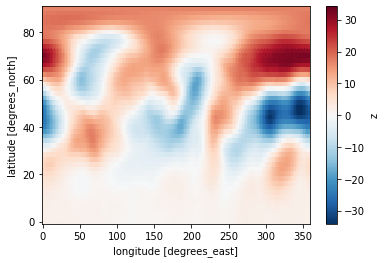

In [4]:
# Composite of WFD
# Get Composite anomoaly for fog days
wfdComp=wfdZ.mean(dim="time")
wfdComp.plot()

In [5]:
wfdZComp_cube=wfdComp.to_iris()
wfdZComp_cube
wfdZComp_cube_small=wfdComp.sel(latitude=slice(50,0),longitude=slice(30,120)).to_iris()
wfdZComp_cube_small

Z (unknown),latitude,longitude
Shape,26,46
Dimension coordinates,,
latitude,x,-
longitude,-,x


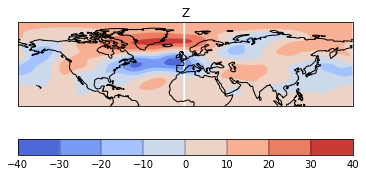

In [6]:
# Draw the contours, with n-levels set for the map colours (9).
# NOTE: needed as the map is non-interpolated, but matplotlib does not provide
# any special behaviour for these.
qplt.contourf(wfdZComp_cube,cmap='coolwarm')

# Add coastlines to the map created by contourf.
plt.gca().coastlines()

plt.show()

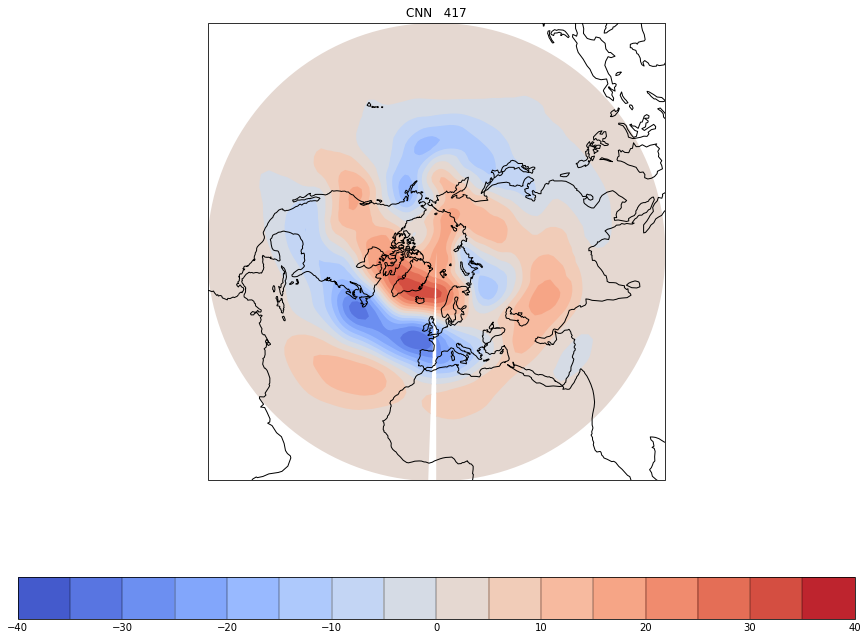

In [7]:
fig = plt.figure(figsize=(15,12))
levels = (-40,-35,-30,-25,-20,-15,-10,-5, 0,5,10,15,20,25,30,35,40)
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
#ax.set_global()

# Northern Hemisphere from 23 degrees north:
ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
qplt.contourf(wfdZComp_cube,cmap='coolwarm',levels=levels)
ax.set_title('CNN   '+str(ndays))
ax.coastlines()
plt.savefig('CNN_WFD-Comp.eps')
qplt.show()

#plt.show()

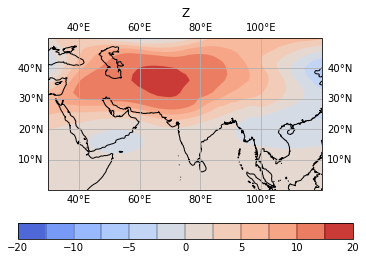

In [8]:
levels = (-20,-15,-10,-7.5,-5, -2.5,0,2.5,5,7.5,10,15,20)

qplt.contourf(wfdZComp_cube_small, cmap='coolwarm',levels=levels)

#qplt.contourf(wfdZComp_cube, brewer_cmap.N, cmap=brewer_cmap,levels=levels)

# Add coastlines to the map created by contourf.
plt.gca().coastlines()
plt.gca().gridlines(draw_labels=True)

plt.show()

# Positive Anomalies 

In [9]:
zwidePos=wfdZ.where(wfdZ.sel(latitude=slice(40,20),longitude=slice(60,85)).mean(dim=['latitude','longitude']) > 0.0, drop=True)
PosCnt=zwidePos.time.sizes
print(PosCnt)
zwidePosComp=zwidePos.mean(dim="time")

Frozen({'time': 264})


In [10]:
zwidePosComp_cube=zwidePosComp.to_iris()
zwidePosComp_cube
zwidePosComp_cube_small=zwidePosComp.sel(latitude=slice(50,0),longitude=slice(30,120)).to_iris()
zwidePosComp_cube_small

Z (unknown),latitude,longitude
Shape,26,46
Dimension coordinates,,
latitude,x,-
longitude,-,x


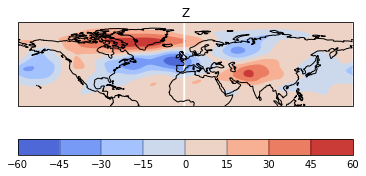

In [11]:
qplt.contourf(zwidePosComp_cube,cmap='coolwarm')

# Add coastlines to the map created by contourf.
plt.gca().coastlines()

plt.show()

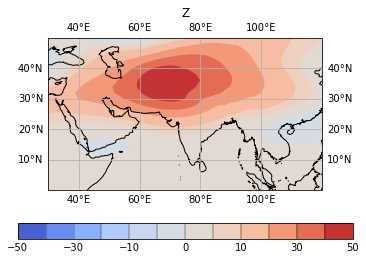

In [12]:
levels = (-50,-40,-30,-20,-10, -5,0,5,10,20,30,40,50)

qplt.contourf(zwidePosComp_cube_small, cmap='coolwarm',levels=levels)

#qplt.contourf(wfdZComp_cube, brewer_cmap.N, cmap=brewer_cmap,levels=levels)

# Add coastlines to the map created by contourf.
plt.gca().coastlines()
plt.gca().gridlines(draw_labels=True)

# Negative Anomalies 

In [13]:
zwideNeg=wfdZ.where(wfdZ.sel(latitude=slice(40,20),longitude=slice(60,85)).mean(dim=['latitude','longitude']) < 0.0, drop=True)
NegCnt=zwideNeg.time.sizes
print(NegCnt)
zwideNegComp=zwideNeg.mean(dim="time")

Frozen({'time': 153})


In [14]:
zwideNegComp_cube=zwideNegComp.to_iris()
zwideNegComp_cube
zwideNegComp_cube_small=zwideNegComp.sel(latitude=slice(50,0),longitude=slice(30,120)).to_iris()
zwideNegComp_cube_small

Z (unknown),latitude,longitude
Shape,26,46
Dimension coordinates,,
latitude,x,-
longitude,-,x


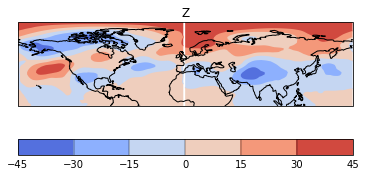

In [15]:
qplt.contourf(zwideNegComp_cube,cmap='coolwarm')

# Add coastlines to the map created by contourf.
plt.gca().coastlines()

plt.show()

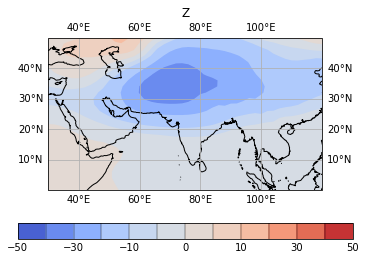

In [16]:
levels = (-50,-40,-30,-20,-10, -5,0,5,10,20,30,40,50)

qplt.contourf(zwideNegComp_cube_small, cmap='coolwarm',levels=levels)

#qplt.contourf(wfdZComp_cube, brewer_cmap.N, cmap=brewer_cmap,levels=levels)

# Add coastlines to the map created by contourf.
plt.gca().coastlines()
plt.gca().gridlines(draw_labels=True)